## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geodatasets

In [2]:
project_data_full = pd.read_csv('My_CHI._My_Future._Programs_20241113.csv')
bus_data_full = pd.read_csv('CTA_BusStops_20241118.csv')
train_data_full = pd.read_csv('CTA_-_System_Information_-_List_of__L__Stops_20241118.csv')

### Distribution of variables
*By Sylvia Sherwood*

In [ ]:
#...Plot for distribution of variables...#

### Data cleaning
*Portion by Owen Handelman*

In [5]:
# Creating useable df for bus data (extracting Latitude and Longitude, only keeping lat, long, and stop name)
bus_lat_long = bus_data_full['the_geom'].str.slice(6).str.replace('(','').str.replace(')','').str.split(' ')
bus_data_full['Longitude'] = pd.to_numeric(bus_lat_long.apply(lambda x: x[0]))
bus_data_full['Latitude'] = pd.to_numeric(bus_lat_long.apply(lambda x: x[1]))
bus_data = bus_data_full.loc[:, ['PUBLIC_NAM', 'Longitude', 'Latitude']]

In [4]:
# getting lat, long, train line, and station name
train_lat_long = train_data_full['Location'].str.replace('(','').str.replace(')','').str.split(',')
train_data_full['Longitude'] = pd.to_numeric(train_lat_long.apply(lambda x: x[1]))
train_data_full['Latitude'] = pd.to_numeric(train_lat_long.apply(lambda x: x[0]))
train_data_full['Line'] = train_data_full.apply(lambda x: 'Red' if x['RED'] == True else 'Blue' if x['BLUE'] == True else 'Green' if x['G'] == True
                                                else 'Brown' if x['BRN'] == True else 'Purple' if x['P'] == True else 'Yellow' if x['Y'] == True
                                                else 'Pink' if x['Pnk'] == True else 'Orange', axis = 1)
train_data = train_data_full.loc[:, ['STATION_DESCRIPTIVE_NAME', 'Longitude', 'Latitude', 'Line']]

In [6]:
# cleaning Participants Paid to True or False for better graphing, only keeping used columns (and program ID for identificiation while coding)
project_data = project_data_full.loc[:,['Program ID', 'Meeting Type', 'Scholarship Available', 'Participants Paid', 'Transport Provided', 'Has Free Food', 'Latitude', 'Longitude']]
project_data['Participants Paid'] = project_data['Participants Paid'].apply(lambda x: True if x == 'Paid, Type Unknown' else False if x == 'Not Paid' else np.nan)

In [8]:
# making subdataset to use for face-to-face data (must have location data)
project_data_f2f = project_data[~project_data_full['Location'].isna()]
project_data_f2f = project_data_f2f[project_data_f2f['Meeting Type'] == 'face_to_face']
project_data_f2f.drop_duplicates(subset='Program ID', inplace=True)

### Data preparation
*Portion by Owen Handelman*


In [7]:
radius = 3957.297 # estimation of the Earth's radius at Chicago's Latitude in miles
radius *= 5280 # radius estimate converted to feet
bus_long = np.deg2rad(bus_data['Longitude']) # preparing bus stop data for haversine
bus_lat = np.deg2rad(bus_data['Latitude'])
def dist_to_closest_bus_station(lat, long): # finds minimum haversine distance between program location and a bus stop
    program_long = np.deg2rad(long)
    program_lat = np.deg2rad(lat)
    diff_long = bus_long - program_long
    diff_lat = bus_lat- program_lat

    add = np.cos(program_lat) * np.cos(bus_lat) * np.sin(diff_long * 0.5) ** 2
    d = np.sin(diff_lat * 0.5) ** 2 + add
    h = 2 * radius * np.arcsin(np.sqrt(d))
    return(h.min())

train_long = np.deg2rad(train_data['Longitude']) # prepares train stop data
train_lat = np.deg2rad(train_data['Latitude'])
def dist_to_closest_train_station(lat, long): # finds distance to nearest train station in feet using haversine
    program_long = np.deg2rad(long)
    program_lat = np.deg2rad(lat)
    diff_long = train_long - program_long
    diff_lat = train_lat- program_lat

    add = np.cos(program_lat) * np.cos(train_lat) * np.sin(diff_long * 0.5) ** 2
    d = np.sin(diff_lat * 0.5) ** 2 + add
    h = 2 * radius * np.arcsin(np.sqrt(d))
    idx = h.idxmin()
    return(pd.Series([h.min(), train_data['Line'][idx]]))

In [9]:
project_data_f2f['Distance to Closest Bus Station (ft)'] = project_data_f2f.apply(lambda row: dist_to_closest_bus_station(row.Latitude, row.Longitude), axis = 1)
project_data_f2f[['Distance to Closest Train Station (ft)', 'Closest Train Line']] = project_data_f2f.apply(lambda row: dist_to_closest_train_station(row.Latitude, row.Longitude), axis = 1)


In [10]:
project_data_f2f.sort_values('Distance to Closest Bus Station (ft)', ascending=False).head(8)

,Program ID,Meeting Type,Scholarship Available,Participants Paid,Transport Provided,Has Free Food,Latitude,Longitude,Distance to Closest Bus Station (ft),Distance to Closest Train Station (ft),Closest Train Line
372622,94624,face_to_face,False,False,False,False,40.015900,-120.961998,9.085801e+06,9.070352e+06,Blue
370121,94583,face_to_face,False,False,False,False,40.015900,-120.961998,9.085801e+06,9.070352e+06,Blue
344316,175001,face_to_face,False,NaN,NaN,NaN,38.922466,-94.731972,2.163517e+06,2.197046e+06,Blue
373432,121052,face_to_face,True,False,False,True,39.482399,-88.172798,8.069517e+05,8.308609e+05,Red
370593,137468,face_to_face,False,NaN,NaN,NaN,41.758400,-88.317200,1.178404e+05,1.377383e+05,Blue
370932,144406,face_to_face,False,NaN,NaN,NaN,42.035400,-88.230698,1.062665e+05,9.093925e+04,Blue
91751,202814,face_to_face,False,True,NaN,False,42.126797,-88.076065,7.858434e+04,7.157509e+04,Blue
370085,135987,face_to_face,False,NaN,NaN,NaN,41.866299,-88.105202,7.391032e+04,6.799511e+04,Blue


The first three places are not in Illinois and therefore make sense to remove.
The fourth greatest distance to closest bus station entry is in Charleston IL (south of Springfield) and also makes sense to remove.
The Fifth is in Aurora, which I think is close enough to justify its inclusion (which also means every subsequent program is closer and more reasonable to include)

In [11]:
project_data_f2f = project_data_f2f.sort_values('Distance to Closest Bus Station (ft)', ascending=False)
project_data_f2f = project_data_f2f.copy().iloc[4:] 
# removing the furthest four programs as their coordinates put them outside a reasonable bound of Chicago

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Analysis 1
*By \<Name of person doing the analysis>*

### Analysis 2
*By \<Name of person doing the analysis>*

### Analysis 3
*By \<Name of person doing the analysis>*

### Analysis 4
*By Owen Handelman*

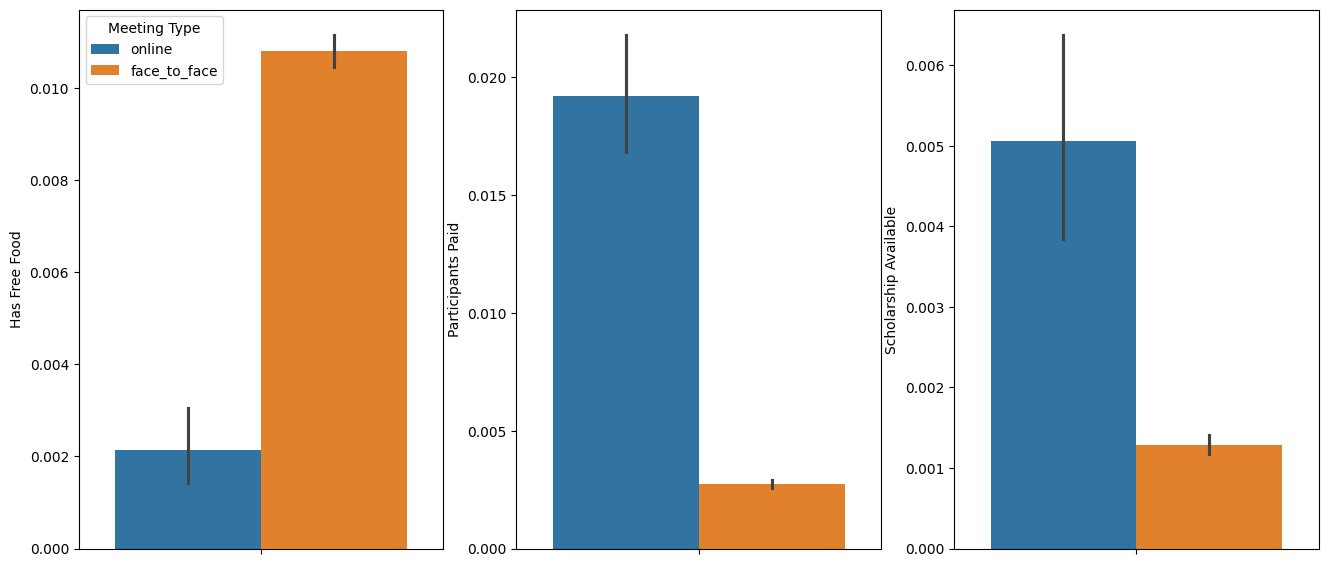

In [12]:
# figure for comparing online and in-person programs in assistance provided
# comparing if the program offers food, transportation, and scholarships
fig, axs = plt.subplots(1,3,figsize=(16,7))
sns.barplot(project_data, y='Has Free Food', hue = 'Meeting Type', ax=axs[0])
sns.barplot(project_data, y='Participants Paid', hue = 'Meeting Type', ax=axs[1])
sns.barplot(project_data, y='Scholarship Available', hue = 'Meeting Type', ax=axs[2])
axs[1].get_legend().remove()
axs[2].get_legend().remove()

Text(0.5, 1.0, 'CTA Train Station Map')

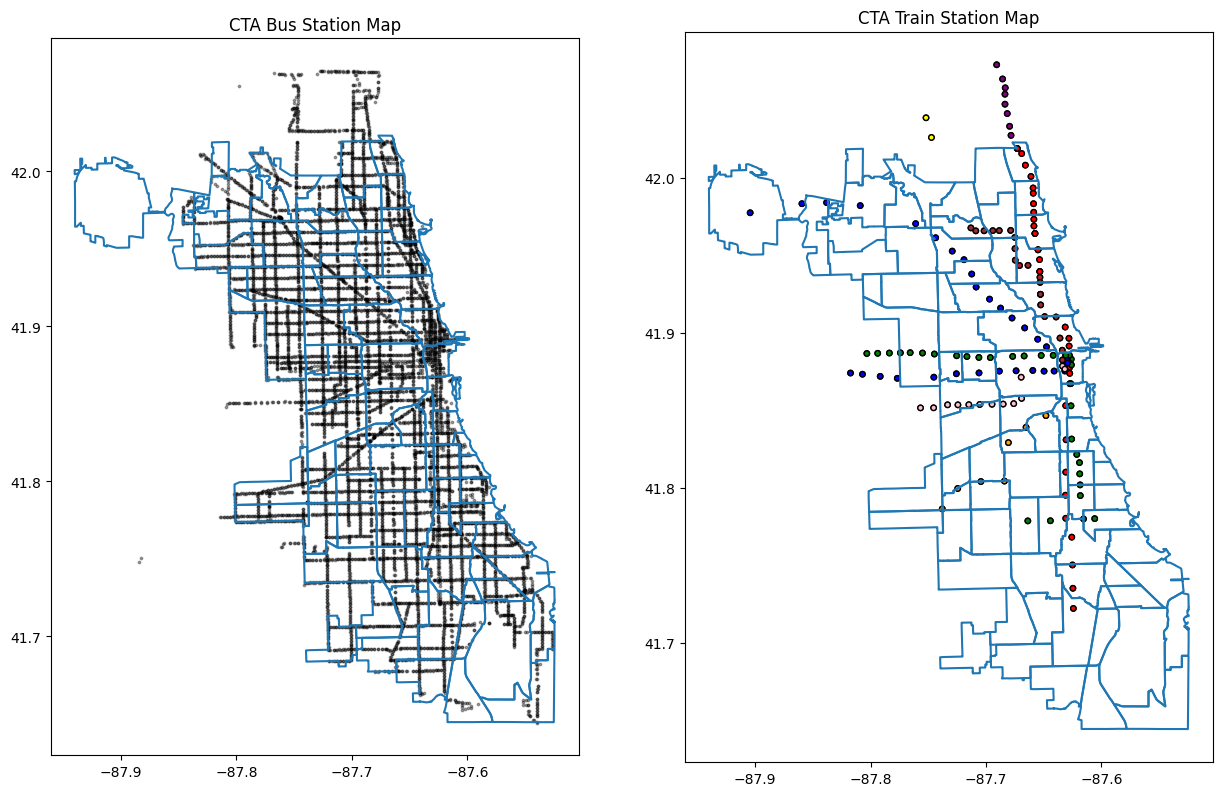

In [13]:

# creating plot of bus and train stations (train stations are color coded)
chicago = gpd.read_file(geodatasets.get_path('geoda.chicago_commpop'))
fig, axes = plt.subplots(1,2,figsize=(15,10))
chicago.boundary.plot(ax=axes[0])
axes[0].scatter(x= bus_data['Longitude'], y = bus_data['Latitude'], s = 3, alpha = 0.35, color ='black')
axes[0].set_title('CTA Bus Station Map')
chicago.boundary.plot(ax=axes[1])
train_color_dict = {'Pink': 'pink', 'Green':'green', 'Blue':'blue', 'Brown':'brown', 'Purple':'purple', 'Red':'red', 'Orange':'orange', 'Yellow':'yellow'}
axes[1].scatter(x= train_data['Longitude'], y = train_data['Latitude'], s = 15, c=[train_color_dict[cat] for cat in train_data['Line']], edgecolors='black')
axes[1].set_title('CTA Train Station Map')

Text(0.5, 1.0, 'Programs That Do Provided Transportation')

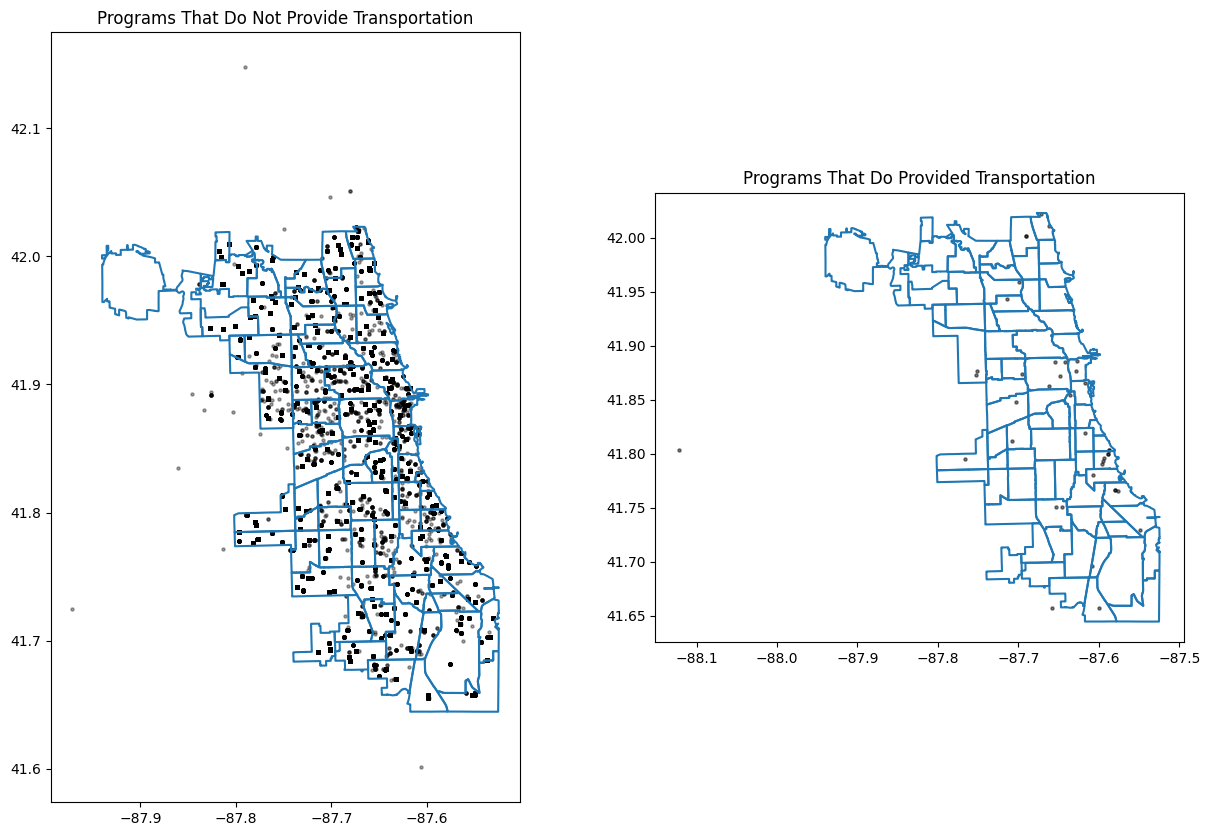

In [14]:
# plot the location of programs that do and do not provide transport
f2f_transport_yes = project_data_f2f[project_data_f2f['Transport Provided'] == True]
f2f_transport_no = project_data_f2f[project_data_f2f['Transport Provided'] == False]

chicago = gpd.read_file(geodatasets.get_path('geoda.chicago_commpop'))
fig, axes = plt.subplots(1,2,figsize=(15,10))
chicago.boundary.plot(ax=axes[0])
axes[0].scatter(x= f2f_transport_no['Longitude'], y = f2f_transport_no['Latitude'], s = 5, alpha = 0.35, color ='black')
axes[0].set_title('Programs That Do Not Provide Transportation')
chicago.boundary.plot(ax=axes[1])
axes[1].scatter(x= f2f_transport_yes['Longitude'], y = f2f_transport_yes['Latitude'], s = 5, alpha=0.5, c='black')
axes[1].set_title('Programs That Do Provided Transportation')

Text(0.5, 1.0, 'Programs That Do Provided Transportation')

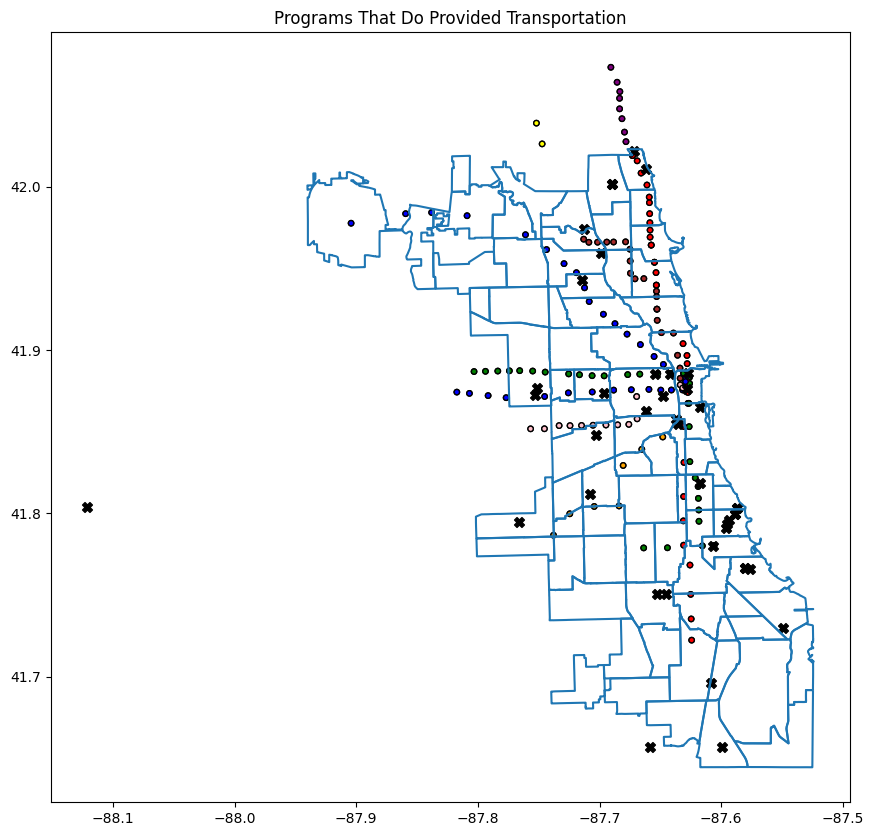

In [16]:
# overlaying train station map and map of programs that offer transportation
chicago = gpd.read_file(geodatasets.get_path('geoda.chicago_commpop'))
fig, axes = plt.subplots(figsize=(15,10))
chicago.boundary.plot(ax=axes)
train_color_dict = {'Pink': 'pink', 'Green':'green', 'Blue':'blue', 'Brown':'brown', 'Purple':'purple', 'Red':'red', 'Orange':'orange', 'Yellow':'yellow'}
axes.scatter(x= train_data['Longitude'], y = train_data['Latitude'], s = 15, c=[train_color_dict[cat] for cat in train_data['Line']], edgecolors='black')
axes.scatter(x= f2f_transport_yes['Longitude'], y = f2f_transport_yes['Latitude'], s = 50, c='black', marker='X')
axes.set_title('Programs That Do Provided Transportation')

Text(0.5, 1.0, 'Programs that provide Transport')

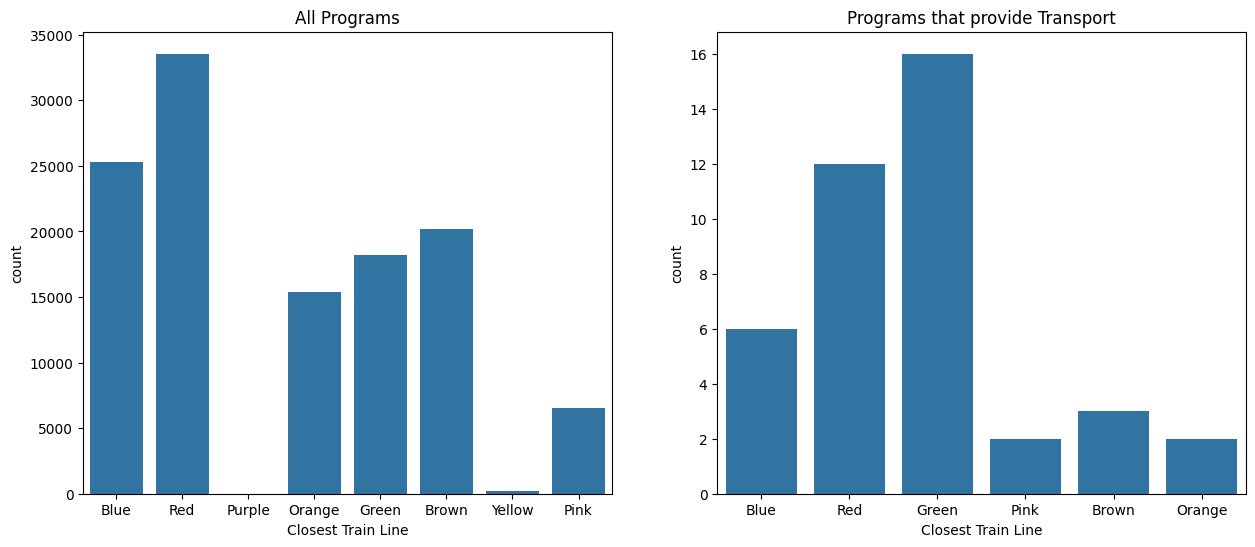

In [17]:
# figure showing the number of programs that are closest to each train line
fig, axs = plt.subplots(1,2,figsize=(15,6))
sns.countplot(project_data_f2f, x = 'Closest Train Line', ax= axs[0])
sns.countplot(project_data_f2f[project_data_f2f['Transport Provided'] == True], x = 'Closest Train Line', ax= axs[1])
axs[0].set_title('All Programs')
axs[1].set_title('Programs that provide Transport')

<Axes: xlabel='Scholarship Available', ylabel='Distance to Closest Bus Station (ft)'>

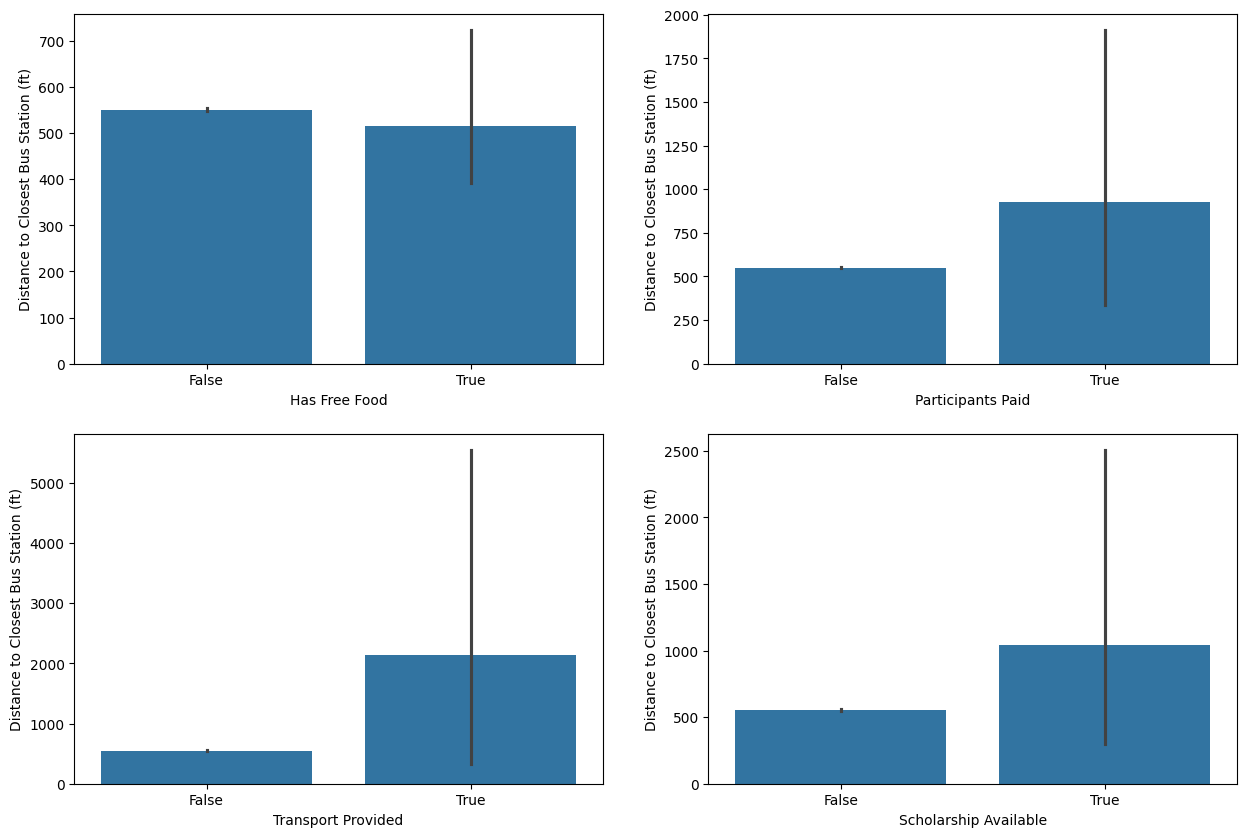

In [18]:
# comparing differences in the average distance to closest bus station between programs that do and do not provide assistance
fig, axs = plt.subplots(2,2,figsize=(15,10))
sns.barplot(data=project_data_f2f, x='Has Free Food', y='Distance to Closest Bus Station (ft)', ax=axs[0,0])
sns.barplot(data=project_data_f2f, x='Participants Paid', y='Distance to Closest Bus Station (ft)', ax=axs[0,1])
sns.barplot(data=project_data_f2f, x='Transport Provided', y='Distance to Closest Bus Station (ft)', ax=axs[1,0])
sns.barplot(data=project_data_f2f, x='Scholarship Available', y='Distance to Closest Bus Station (ft)', ax=axs[1,1])

<Axes: xlabel='Scholarship Available', ylabel='Distance to Closest Train Station (ft)'>

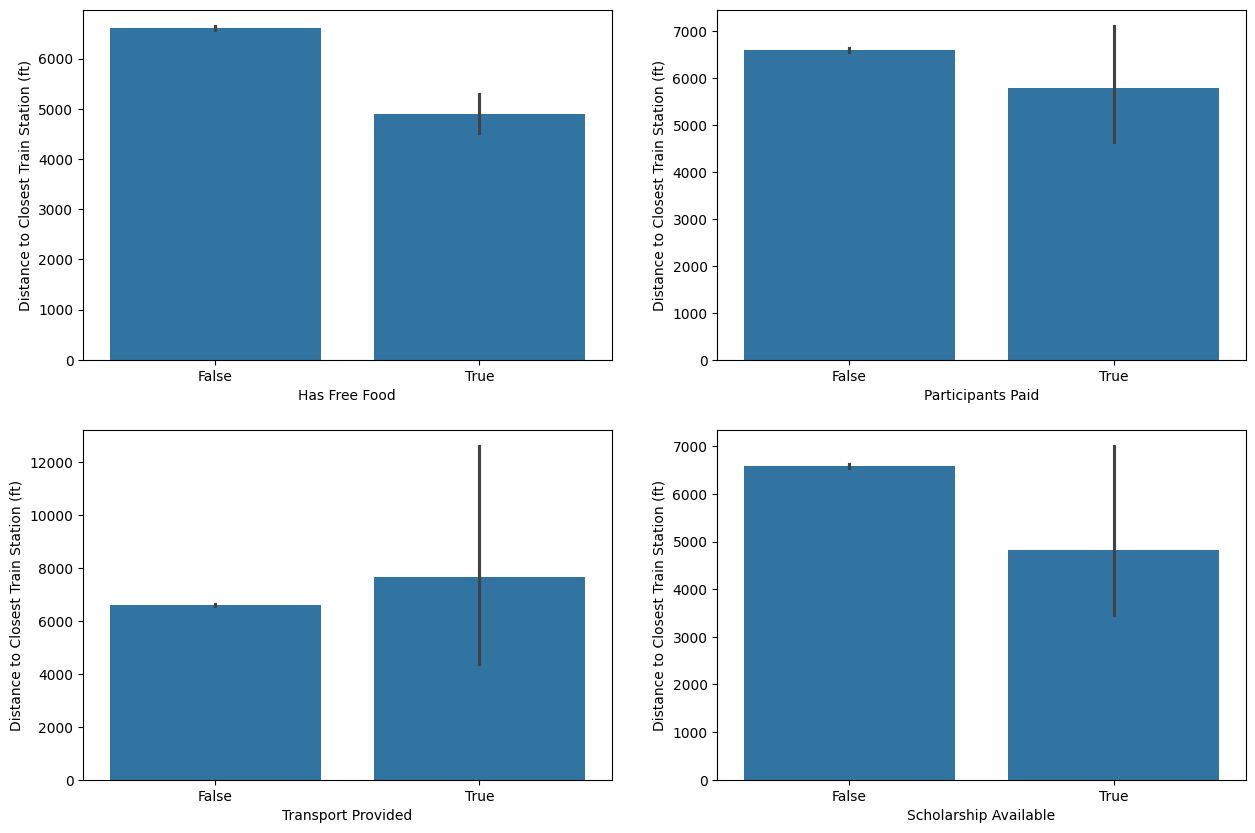

In [19]:
# comparing differences in the average distance to closest train station between programs that do and do not provide assistance
fig, axs = plt.subplots(2,2,figsize=(15,10))
sns.barplot(data=project_data_f2f, x='Has Free Food', y='Distance to Closest Train Station (ft)', ax=axs[0,0])
sns.barplot(data=project_data_f2f, x='Participants Paid', y='Distance to Closest Train Station (ft)', ax=axs[0,1])
sns.barplot(data=project_data_f2f, x='Transport Provided', y='Distance to Closest Train Station (ft)', ax=axs[1,0])
sns.barplot(data=project_data_f2f, x='Scholarship Available', y='Distance to Closest Train Station (ft)', ax=axs[1,1])